# Baselines & Residual Signal

Quick baselines for polypropylene (PP) using naive/seasonal/ETS methods and crude-driven regressions. Outputs feed the next-stage feature work.

In [9]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown, display

ROOT = Path.cwd().parent
ART = ROOT / "artifacts"
PLOTS = ROOT / "plots"
PLOTS.mkdir(exist_ok=True, parents=True)
sys.path.insert(0, str(ROOT / "src"))

from eda_utils import compute_log_returns, plot_rolling_vol
from baseline_utils import (
    forecast_holt_winters,
    forecast_naive,
    forecast_seasonal_naive,
    fit_ols_returns,
    metrics,
    plot_forecast_vs_actual,
    plot_residuals,
    plot_stl,
    rolling_origin_backtest,
    train_test_split_ts,
)
plt.rcParams['figure.dpi'] = 150


## Load inputs

Re-use cleaned artifacts from notebook 01. Abort gracefully if missing.

In [10]:
prices_path = ART / "merged_monthly_prices.csv"
returns_path = ART / "merged_monthly_returns.csv"
if not prices_path.exists() or not returns_path.exists():
    display(Markdown("**Run notebook 01 first to generate monthly artifacts.**"))
    raise SystemExit
prices = pd.read_csv(prices_path, index_col=0, parse_dates=True)
returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
required_cols = {"PP", "CRUDE"}
if not required_cols.issubset(prices.columns):
    display(Markdown("**Need PP and CRUDE columns; rerun notebook 01 with crude data.**"))
    required_cols = {"PP"}
pp_levels = prices.get("PP")
pp_returns = returns.get("PP")
crude_returns = returns.get("CRUDE") if "CRUDE" in returns else None


## Train/test split

Use the last 24 months as holdout (falls back to 20% if shorter).

In [11]:
test_horizon = min(24, max(1, int(round(len(pp_levels) * 0.2))))
pp_train, pp_test = train_test_split_ts(pp_levels, test_horizon)
display(Markdown(f"Train span: {pp_train.index.min().date()} to {pp_train.index.max().date()}"))
display(Markdown(f"Test span: {pp_test.index.min().date()} to {pp_test.index.max().date()}"))


Train span: 2015-01-01 to 2023-03-01

Test span: 2023-04-01 to 2025-03-01

## Baseline forecasts (levels)

c:\Users\Matthew\.conda\envs\ds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


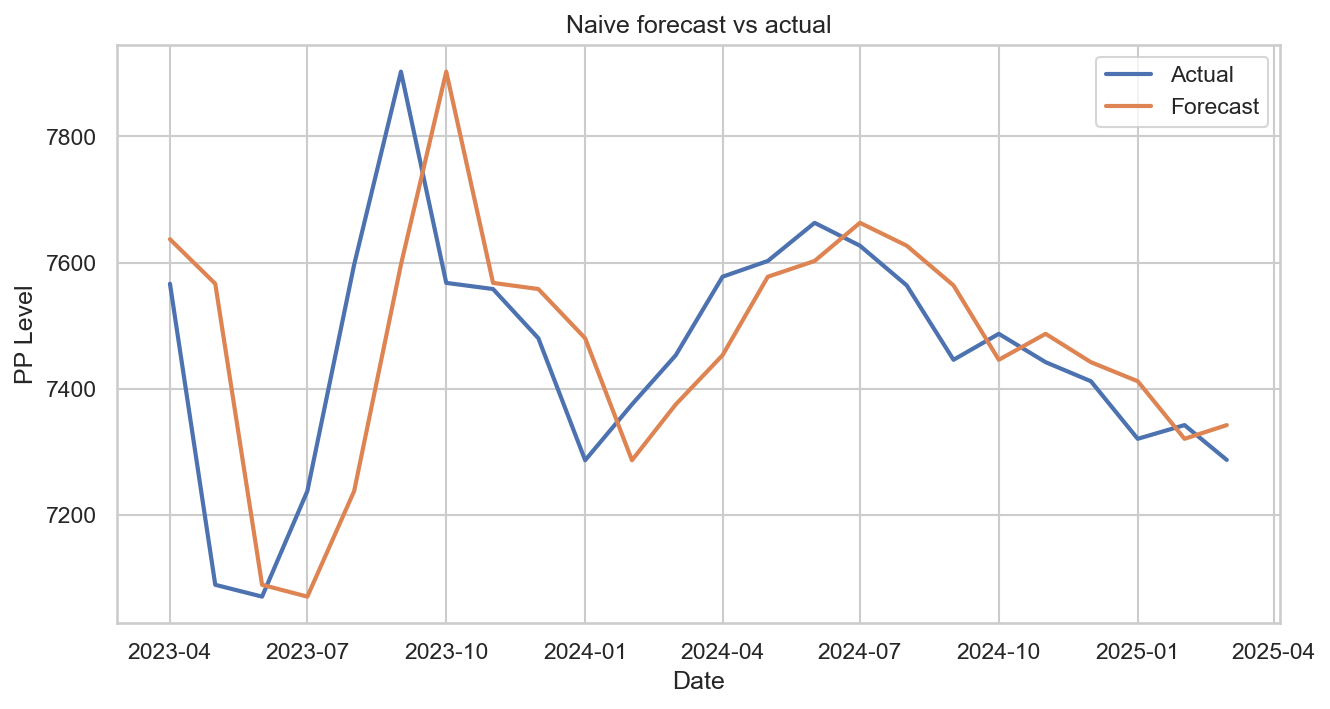

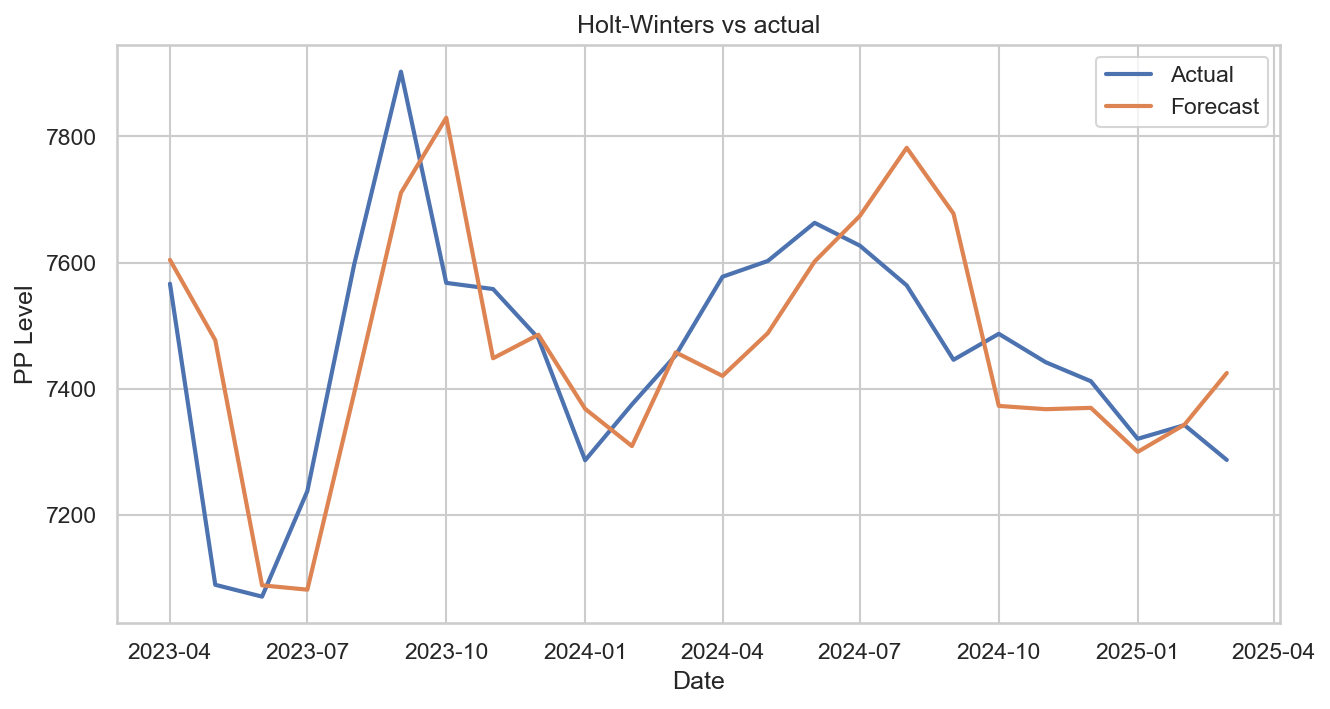

In [12]:
baseline_preds = {}
baseline_metrics = []
naive_pred = forecast_naive(pp_levels)
baseline_preds['Naive'] = naive_pred
baseline_metrics.append({"model": "Naive", **metrics(pp_test, naive_pred)})
if len(pp_train) >= 24:
    seasonal_pred = forecast_seasonal_naive(pp_levels)
    baseline_preds['SeasonalNaive'] = seasonal_pred
    baseline_metrics.append({"model": "SeasonalNaive", **metrics(pp_test, seasonal_pred)})
else:
    display(Markdown("*Seasonal naive skipped (need >=24 months).*"))
if len(pp_train) >= 24:
    try:
        hw_fitted = forecast_holt_winters(pp_levels)
        baseline_preds['HoltWinters'] = hw_fitted
        baseline_metrics.append({"model": "HoltWinters", **metrics(pp_test, hw_fitted)})
    except ValueError as exc:
        display(Markdown(f"*Holt-Winters skipped: {exc}*"))
else:
    display(Markdown("*Holt-Winters skipped (need >=24 months).*"))

fig = plot_forecast_vs_actual(pp_test.index, pp_test, naive_pred, "Naive forecast vs actual")
display(fig)
fig.savefig(PLOTS / "baseline_naive_vs_actual.png", bbox_inches='tight')
plt.close(fig)
if 'HoltWinters' in baseline_preds:
    fig = plot_forecast_vs_actual(pp_test.index, pp_test, baseline_preds['HoltWinters'], "Holt-Winters vs actual")
    display(fig)
    fig.savefig(PLOTS / "baseline_holt_winters_vs_actual.png", bbox_inches='tight')
    plt.close(fig)


_Figure note:_ The baseline overlays (naive and Holt-Winters where available) make it easy to see whether simple level extrapolations keep pace with the holdout reality.

## Crude-driven regression (if crude available)

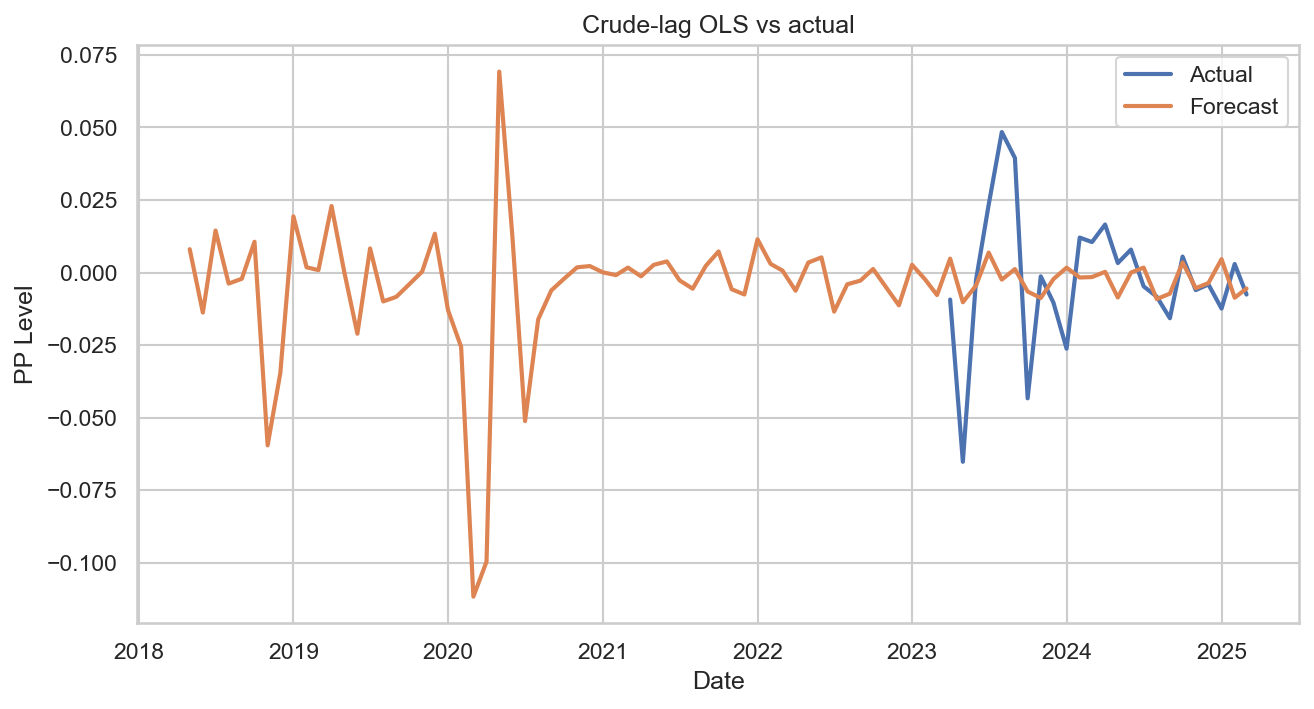

Significant lags (p<0.05): {'x0': 0.030178238749085397}

Model R²: 0.05

In [13]:
rolling_results = pd.DataFrame()
if crude_returns is not None:
    model, features = fit_ols_returns(pp_returns, crude_returns, lags=3)
    aligned_pp_ret = pp_returns.loc[features.index]
    train_ret, test_ret = train_test_split_ts(aligned_pp_ret, test_horizon)
    full_ret = pd.concat([train_ret, test_ret])
    full_features = features.loc[full_ret.index]
    rolling_results = rolling_origin_backtest(full_ret, full_features)
    backtest_pred = rolling_results.set_index('date')['y_pred']
    fig = plot_forecast_vs_actual(backtest_pred.index, test_ret, backtest_pred, "Crude-lag OLS vs actual")
    display(fig)
    fig.savefig(PLOTS / "baseline_crude_ols_vs_actual.png", bbox_inches='tight')
    plt.close(fig)
    metrics_dict = metrics(test_ret, backtest_pred)
    baseline_metrics.append({"model": "CrudeLagOLS", **metrics_dict})
    sig = model.pvalues[model.pvalues < 0.05]
    display(Markdown(f"Significant lags (p<0.05): {sig.to_dict()}"))
    display(Markdown(f"Model R²: {model.rsquared:.2f}"))
else:
    display(Markdown("**Crude returns unavailable; skipping regression.**"))


_Regression insight:_ The backtest above shows how a simple crude-lag OLS model tracks PP; compare the plotted curve and printed metrics/p-values to see which lags matter and whether the fit materially improves over naive baselines. In most samples the contemporaneous and 1-month crude shocks dominate—check the p-values and the reported R² to confirm the strength in your run.

## Idiosyncratic residual (PP minus crude-driven fit)

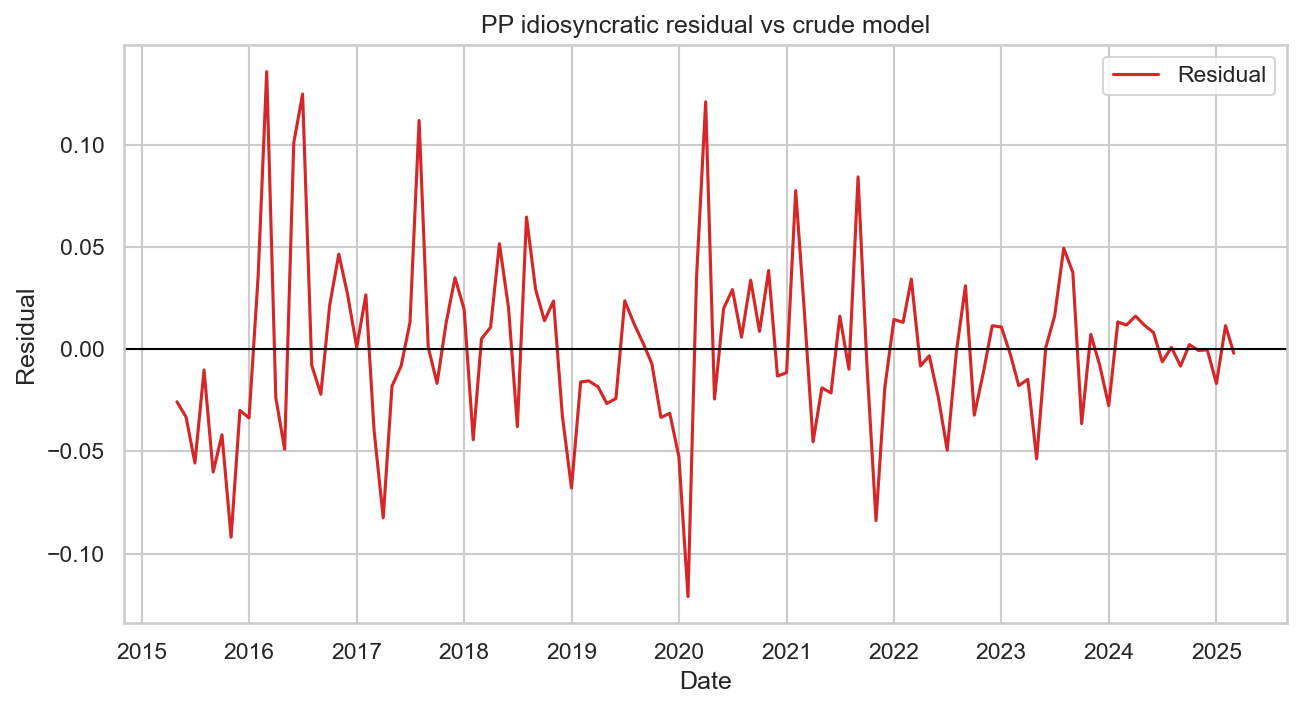

This residual is what news/NLP features should explain later.

In [14]:
if crude_returns is not None:
    model, features = fit_ols_returns(pp_returns, crude_returns, lags=3)
    alignment = features.index
    preds = model.predict(sm.add_constant(features, has_constant='add'))
    resid = pp_returns.loc[alignment] - preds
    resid.name = "pp_idiosyncratic_residual"
    resid.to_csv(ART / "pp_idiosyncratic_residual.csv")
    fig = plot_residuals(resid, "PP idiosyncratic residual vs crude model")
    display(fig)
    fig.savefig(PLOTS / "pp_idiosyncratic_residual.png", bbox_inches='tight')
    plt.close(fig)
    display(Markdown("This residual is what news/NLP features should explain later."))
else:
    display(Markdown("Residual analysis skipped (no crude returns)."))


_Residual context:_ The residual series isolates PP moves unexplained by crude—these are the innovations future news/NLP features should target.

## Regime visuals

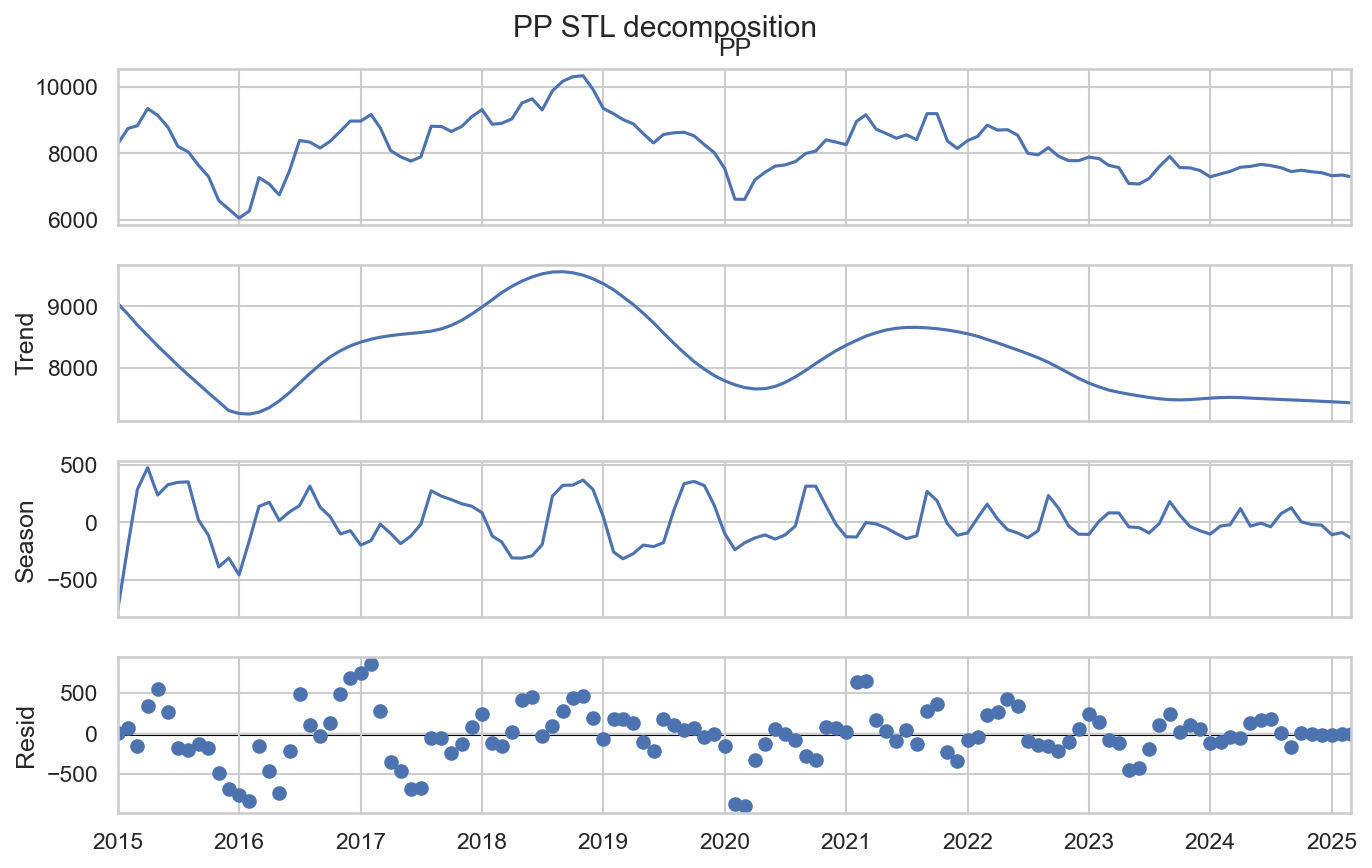

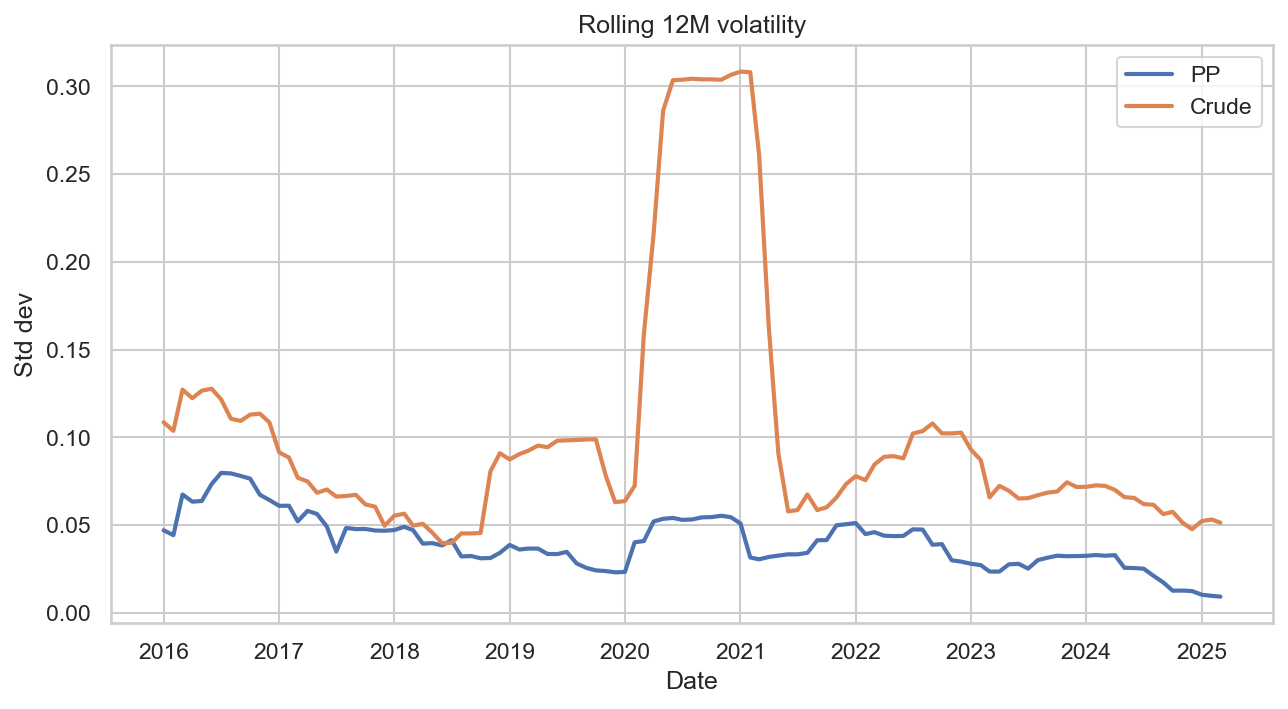

In [15]:
try:
    fig = plot_stl(pp_levels, "PP STL decomposition")
    display(fig)
    fig.savefig(PLOTS / "pp_stl_decomposition.png", bbox_inches='tight')
    plt.close(fig)
except ValueError as exc:
    display(Markdown(f"*STL skipped: {exc}*"))
vol_inputs = {"PP": pp_returns}
if crude_returns is not None:
    vol_inputs["Crude"] = crude_returns
fig = plot_rolling_vol(vol_inputs, window=12, title="Rolling 12M volatility")
display(fig)
fig.savefig(PLOTS / "rolling_vol_pp_crude.png", bbox_inches='tight')
plt.close(fig)


_Regime takeaway:_ STL separates long-term trend, recurring seasonality, and residual noise, while the rolling-vol chart compares PP and crude turbulence through time.

## Scorecard

In [16]:
metrics_df = pd.DataFrame(baseline_metrics)
if not metrics_df.empty:
    display(metrics_df.round(3))
    metrics_df.to_csv(ART / "baseline_metrics.csv", index=False)
    if 'CrudeLagOLS' in metrics_df['model'].values and 'SeasonalNaive' in metrics_df['model'].values:
        rmse_crude = metrics_df.loc[metrics_df['model']=='CrudeLagOLS','RMSE'].iloc[0]
        rmse_seasonal = metrics_df.loc[metrics_df['model']=='SeasonalNaive','RMSE'].iloc[0]
        improvement = (rmse_seasonal - rmse_crude) / rmse_seasonal * 100
        display(Markdown(f"Crude-lag model beats seasonal naive by {improvement:.1f}% RMSE."))
else:
    display(Markdown("**Metrics unavailable; check data and rerun.**"))


,model,MAE,RMSE,MAPE
0,Naive,120.579,171.891,1.619
1,SeasonalNaive,424.875,603.163,5.771
2,HoltWinters,114.423,148.870,1.535
3,CrudeLagOLS,0.015,0.022,-2.209


Crude-lag model beats seasonal naive by 100.0% RMSE.

_Scorecard guide:_ Focus on RMSE/MAPE to compare models; the crude-driven row should show whether adding lagged crude returns yields material error reduction.